# LangSmith Evaluate a Conversational Chat Bot
## 작성자 : AISchool ( http://aischool.ai/%ec%98%a8%eb%9d%bc%ec%9d%b8-%ea%b0%95%ec%9d%98-%ec%b9%b4%ed%85%8c%ea%b3%a0%eb%a6%ac/ )
## Reference : https://github.com/langchain-ai/langsmith-cookbook/blob/main/testing-examples/chat-single-turn/chat_evaluation_single_turn.ipynb

사용자를 돕거나 엔터테인먼트를 제공하도록 설계된 챗봇은 일반적으로 주어진 채팅 세션에서 여러 번의 대화 턴을 수행합니다. **장시간의 상호작용에서는 LLM 응답의 품질이 저하될 가능성**이 있습니다. 이는 이전 대화의 세부 사항을 기억하는 데 어려움을 겪거나 외부 자원과의 부적절한 상호작용(가능한 경우), 반복적이고 영감을 주지 않는 응답으로 나타날 수 있습니다. 현재 오프라인 평가가 개별 질문-응답 쌍에만 초점을 맞춘다면 이러한 미묘한 차이가 감지되지 않을 수 있습니다.

이 walkthrough는 **다중 턴 대화 내에서 챗봇을 평가하기 위한 데이터셋을 만드는 방법**을 안내합니다. 시뮬레이션 기반 방법으로 평가를 복잡하게 만들기보다는, 아래에 설명된 기술은 각 데이터 포인트를 개별 대화 턴으로 간주하여 과정을 단순화합니다. 아래 이미지에는 이 walkthrough에서 사용된 예제 데이터셋의 두 행이 표시되어 있습니다. **사용자의 질문은 맥락 없이 이해하기 어려울 수 있지만, 채팅 기록은 봇이 포함해야 할 내용을 충분히 인식할 수 있는 정보를 제공**합니다.








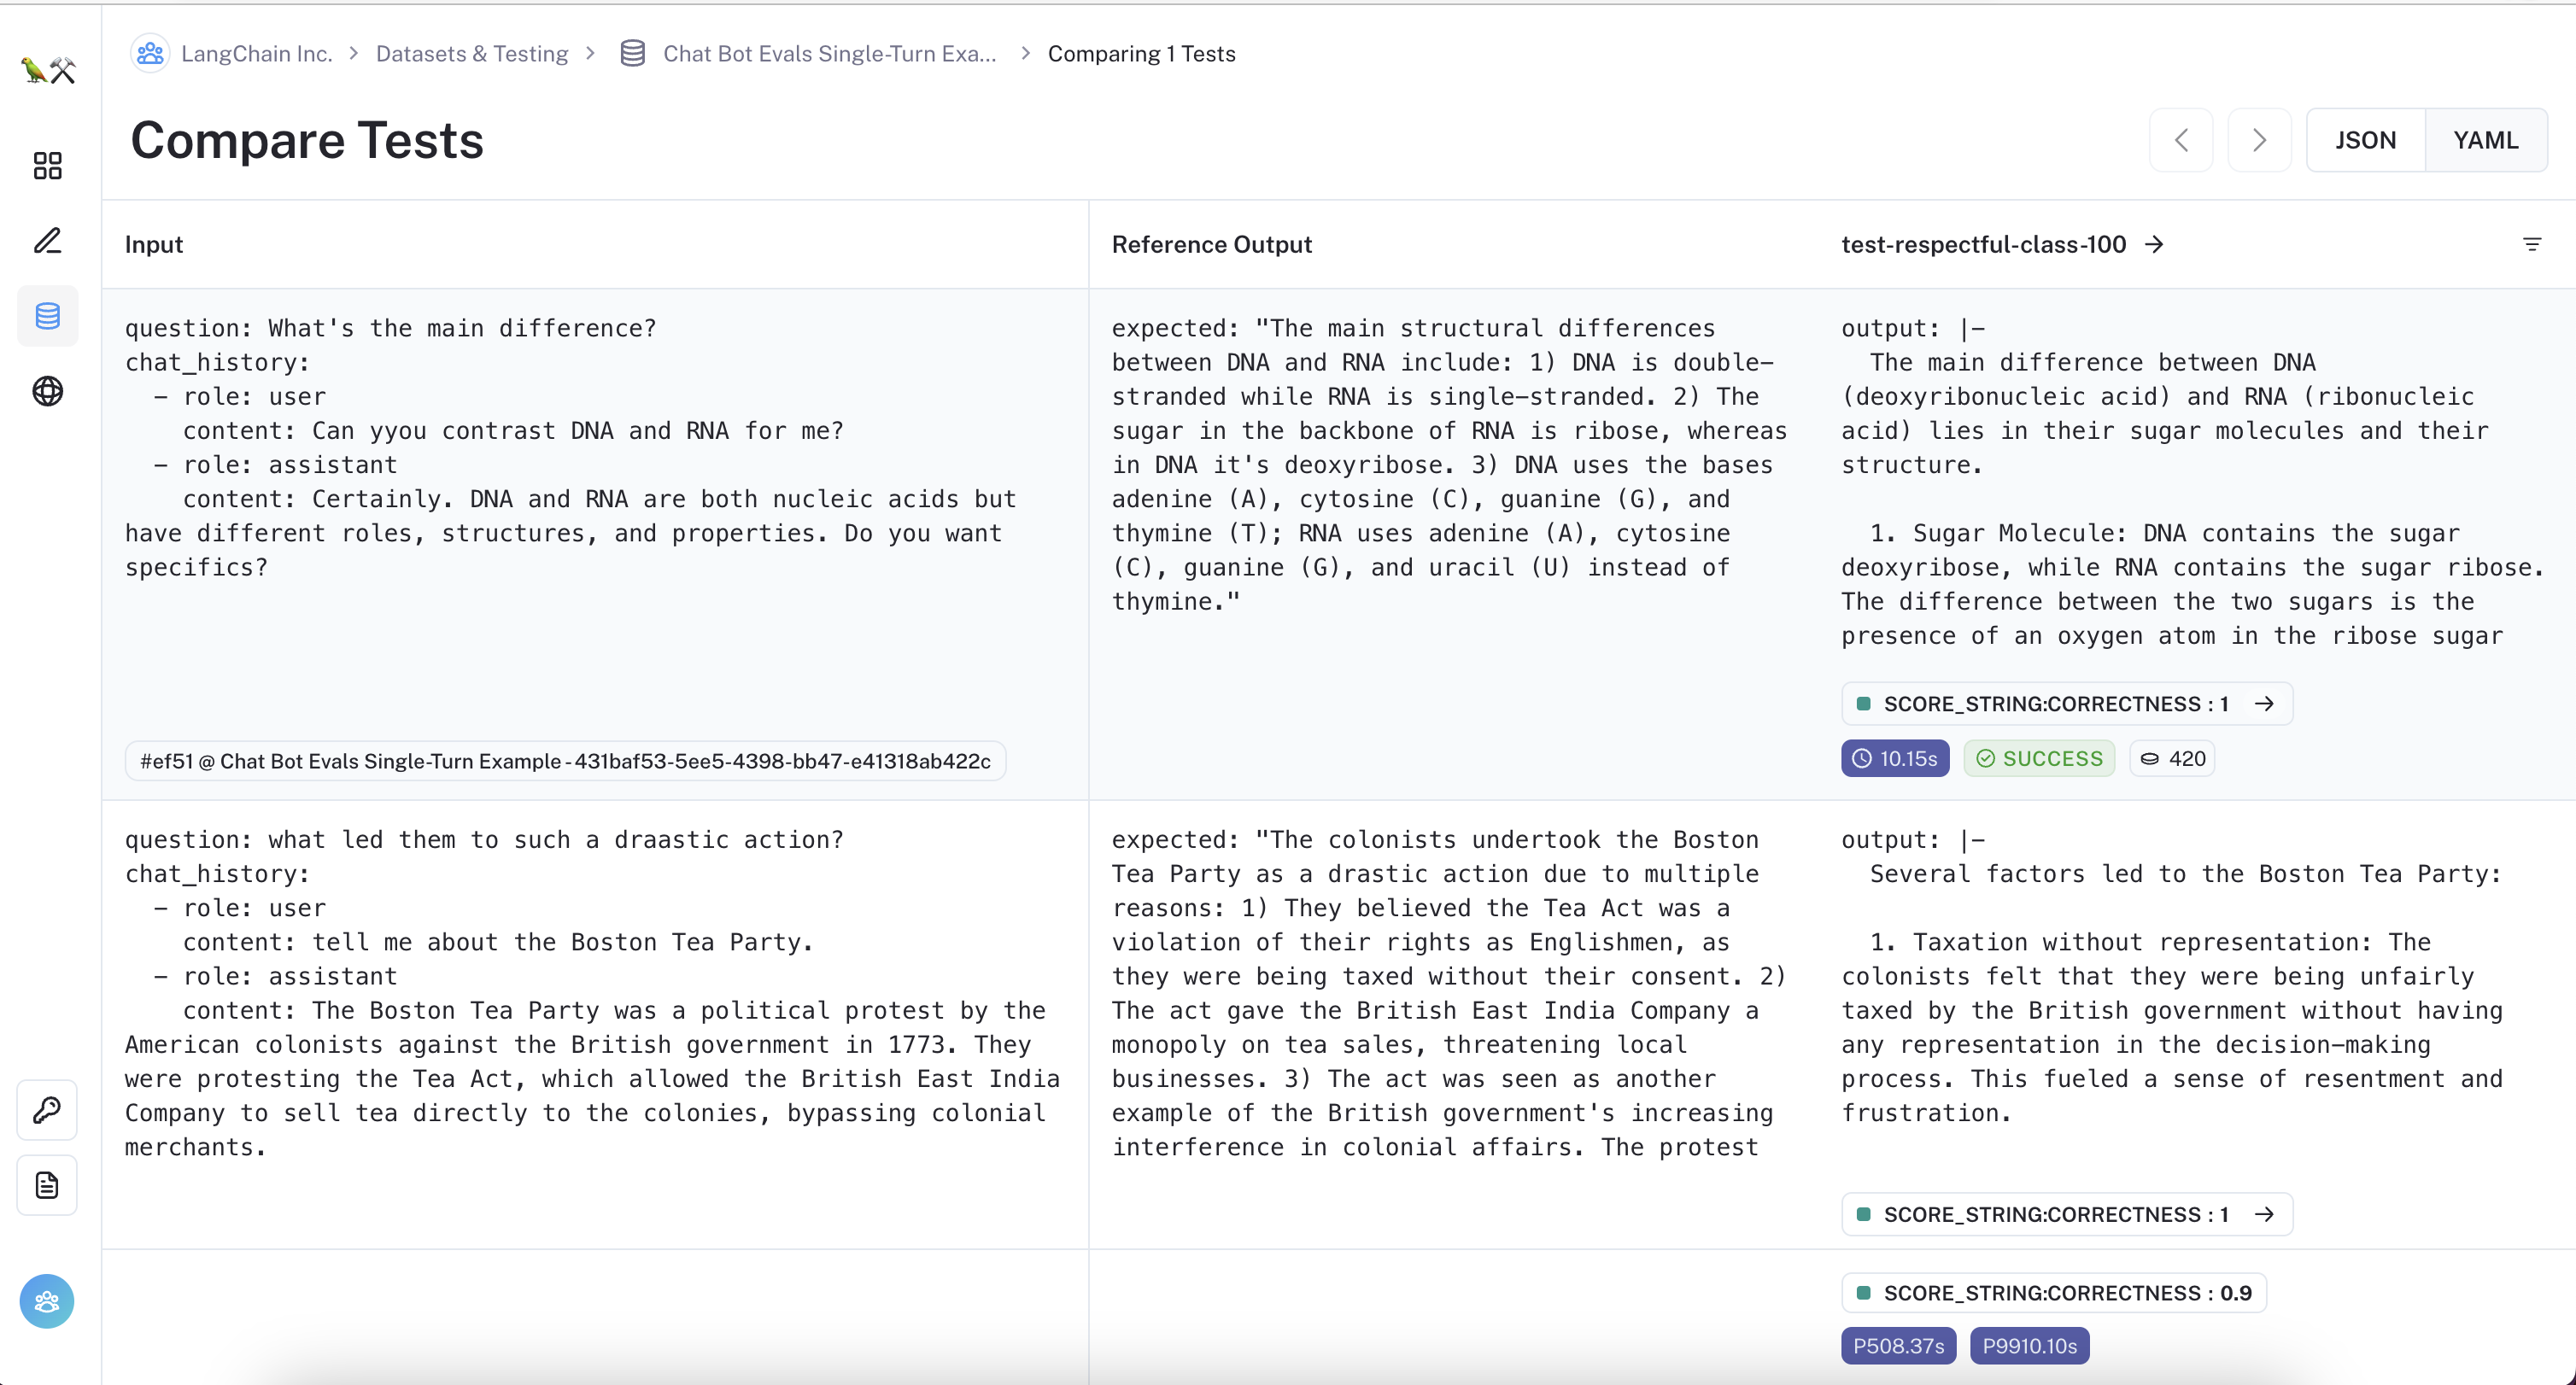

각 대화 턴을 독립적으로 평가하면 추가적인 이점이 있습니다. 예제가 실제 대화의 다양한 단계에서 샘플링되면, 이는 봇이 잘 처리해야 하는 일반적인 시나리오를 효과적으로 포착하고 나타냅니다.

이 노트북은 전체 과정을 간략하게 개요합니다. 시작해봅시다!








# 라이브러리 설치

In [ ]:
!pip install --upgrade --quiet langchain langchain-openai langchainhub langgraph langsmith langchain_community

# Prerequisites

이 walkthrough는 LangChain과 OpenAI를 사용합니다. 아래에서 API 키를 적절히 설정하세요.








In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "여러분의_OPENAI_API_KEY"

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "여러분의_LANGSMITH_API_KEY"

In [ ]:
import uuid

from langsmith import Client

uid = uuid.uuid4()
client = Client()

# 1. Create dataset

다중 턴 대화(multi-turn dialogue) 데이터셋의 핵심 구성 요소는 대화 "턴"(turns) 목록입니다. 각 데이터셋 예제 행에 대해, 우리는 챗봇이 대화 기록을 고려하여 얼마나 잘 응답할 수 있는지 평가할 것입니다.

이를 위해, 우리는 채팅 메시지 사전 목록을 사용하여 데이터셋을 만들 것입니다. "들어오는(incoming)" 사용자 쿼리를 별도의 필드로 분리했습니다.

In [ ]:
examples = [
    {
        "inputs": {
            "question": "How does that apply?",
            "chat_history": [
                {
                    "role": "user",
                    "content": "I’m trying tto uunderstand instein’s theory.",
                },
                {
                    "role": "assistant",
                    "content": "Which one? He's known for several theories.",
                },
                {"role": "user", "content": "Thee one about time and spae."},
                {
                    "role": "assistant",
                    "content": "Ah, you're referring to the theory of relativity. There are two parts: special and general. Which one?",
                },
            ],
        },
        "outputs": {
            "expected": "Special relativity, proposed by Einstein in 1905, deals with objects in uniform motion, especially those moving at the speed of light. It introduced the idea that time and space are relative and can change in relation to each other. For instance, time can appear to move slower for an object moving close to the speed of light."
        },
    },
    {
        "inputs": {
            "question": "What's the main difference?",
            "chat_history": [
                {"role": "user", "content": "Can yyou contrast DNA and RNA for me?"},
                {
                    "role": "assistant",
                    "content": "Certainly. DNA and RNA are both nucleic acids but have different roles, structures, and properties. Do you want specifics?",
                },
            ],
        },
        "outputs": {
            "expected": "The main structural differences between DNA and RNA include: 1) DNA is double-stranded while RNA is single-stranded. 2) The sugar in the backbone of RNA is ribose, whereas in DNA it's deoxyribose. 3) DNA uses the bases adenine (A), cytosine (C), guanine (G), and thymine (T); RNA uses adenine (A), cytosine (C), guanine (G), and uracil (U) instead of thymine."
        },
    },
    {
        "inputs": {
            "question": "what led them to such a draastic action?",
            "chat_history": [
                {"role": "user", "content": "tell me about the Boston Tea Party."},
                {
                    "role": "assistant",
                    "content": "The Boston Tea Party was a political protest by the American colonists against the British government in 1773. They were protesting the Tea Act, which allowed the British East India Company to sell tea directly to the colonies, bypassing colonial merchants.",
                },
            ],
        },
        "outputs": {
            "expected": "The colonists undertook the Boston Tea Party as a drastic action due to multiple reasons: 1) They believed the Tea Act was a violation of their rights as Englishmen, as they were being taxed without their consent. 2) The act gave the British East India Company a monopoly on tea sales, threatening local businesses. 3) The act was seen as another example of the British government's increasing interference in colonial affairs. The protest was a way to show their strong opposition to British policies."
        },
    },
    {
        "inputs": {
            "question": "thats a scary one. can it be avoideed?",
            "chat_history": [
                {"role": "user", "content": "I'm learning bout genetic disorders."},
                {
                    "role": "assistant",
                    "content": "Genetic disorders are diseases caused by abnormalities in an individual's DNA. They can be inherited or result from mutations. One common one is Huntington's disease.",
                },
            ],
        },
        "outputs": {
            "expected": "Huntington's disease is a hereditary genetic disorder caused by a mutation in the HTT gene. If a person inherits the defective gene, they will eventually develop the disease. Currently, there's no cure for Huntington's, but its onset can be delayed with treatment. Genetic counseling and testing can help prospective parents understand the risks of passing the mutation to their offspring."
        },
    },
    {
        "inputs": {
            "question": "Which one?",
            "chat_history": [
                {
                    "role": "user",
                    "content": "I'm confused aboutt stars. what even aaaare they?",
                },
                {
                    "role": "assistant",
                    "content": "Stars are celestial bodies made mostly of hydrogen and helium. They generate light and heat through nuclear fusion in their cores.",
                },
                {
                    "role": "user",
                    "content": "there''s a classification based on theirbrightness, right?",
                },
                {
                    "role": "assistant",
                    "content": "Yes",
                },
            ],
        },
        "outputs": {
            "expected": "Yes, stars are classified based on their brightness using a system called the Hertzsprung-Russell (H-R) diagram. In this diagram, stars are categorized into main-sequence stars, giants, supergiants, and white dwarfs, based on their luminosity and temperature. The Sun, for instance, is a main-sequence star."
        },
    },
]


In [ ]:
dataset_name = f"Chat Bot Evals Single-Turn Example - {uid}"
dataset = client.create_dataset(dataset_name)
client.create_examples(
    inputs=[e["inputs"] for e in examples],
    outputs=[e["outputs"] for e in examples],
    dataset_id=dataset.id,
)

# Step 2: Define chat bot


이 튜토리얼에서는, 우리의 간단한 챗봇이 메시지를 LLM에 맞게 형식화하고 외부 리소스를 참조하지 않고 결과 내용을 응답합니다.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# An example chain
chain = (
    ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful tutor AI."),
            MessagesPlaceholder(variable_name="chat_history"),
            ("user", "{input}"),
        ]
    )
    | ChatOpenAI(model="gpt-3.5-turbo")
    | StrOutputParser()
)

# Step 3: Evaluate


In [ ]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate
from langsmith.schemas import Example, Run
from langchain_community.adapters.openai import convert_openai_messages


def predict(inputs: dict):
    # Add a step to convert the data from the dataset to a form the chain can consume
    return chain.invoke(
        {
            "input": inputs["question"],
            "chat_history": convert_openai_messages(inputs["chat_history"]),
        }
    )


def format_evaluator_inputs(run: Run, example: Example):
    return {
        "input": example.inputs["question"],
        "prediction": next(iter(run.outputs.values())),
        "reference": example.outputs["expected"],
    }


correctness_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={"criteria": "correctness", "normalize_by": 10},
    prepare_data=format_evaluator_inputs,
)

results = evaluate(
    predict,
    data=dataset_name,
    experiment_prefix="Chat Single Turn",
    evaluators=[correctness_evaluator],
    metadata={"model": "gpt-3.5-turbo"},
)

# GPT-4 Evaluation 프롬프트 예시 1

In [ ]:
# [Instruction]
# Please act as an impartial judge and evaluate the quality of the response provided by an AI assistant to the user question displayed below.
# For this evaluation, you should primarily consider the following criteria:
# correctness: Is the submission correct, accurate, and factual?
# [Ground truth]
# The colonists undertook the Boston Tea Party as a drastic action due to multiple reasons: 1) They believed the Tea Act was a violation of their rights as Englishmen, as they were being taxed without their consent. 2) The act gave the British East India Company a monopoly on tea sales, threatening local businesses. 3) The act was seen as another example of the British government's increasing interference in colonial affairs. The protest was a way to show their strong opposition to British policies.
# Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, you must rate the response on a scale of 1 to 10 by strictly following this format: "[[rating]]", for example: "Rating: [[5]]".

# [Question]
# what led them to such a draastic action?

# [The Start of Assistant's Answer]
# The colonists were upset because they saw the Tea Act as a form of taxation without representation, meaning they had no say in the decision to tax them. They viewed it as another way for the British government to exert control over them without their consent. The Boston Tea Party was a way for the colonists to demonstrate their resistance to British policies and assert their independence.
# [The End of Assistant's Answer]


In [ ]:
# [지시사항]
# 공정한 심사관으로서 아래에 표시된 사용자 질문에 대한 AI 어시스턴트의 응답 품질을 평가하세요.
# 이 평가에서는 주로 다음 기준을 고려해야 합니다:
# 정확성: 제출된 답변이 정확하고 사실에 부합합니까?
# [정답]
# 식민지 주민들은 여러 가지 이유로 보스턴 티 파티를 극단적인 행동으로 선택했습니다: 1) 그들은 차법이 그들의 동의 없이 과세된다고 믿어 영국인으로서의 권리를 침해한다고 생각했습니다. 2) 이 법은 영국 동인도 회사에 차 판매 독점을 부여하여 지역 사업을 위협했습니다. 3) 이 법은 영국 정부가 식민지 문제에 점점 더 간섭하고 있다는 또 다른 예로 보였습니다. 이 시위는 영국 정책에 대한 강한 반대 의사를 표명하기 위한 방법이었습니다.
# 설명을 제공하는 것으로 평가를 시작하세요. 가능한 한 객관적으로 작성하세요. 설명을 제공한 후에는 반드시 이 형식에 따라 1에서 10까지의 점수로 응답을 평가하세요: "[[rating]]", 예를 들어: "Rating: [[5]]".

# [질문]
# 그들이 그런 극단적인 행동을 취하게 된 이유는 무엇입니까?

# [어시스턴트의 답변 시작]
# 식민지 주민들은 차법을 그들의 동의 없이 부과되는 세금의 한 형태로 보았기 때문에 화가 났습니다. 그들은 그것을 영국 정부가 그들의 동의 없이 그들에 대한 통제권을 행사하는 또 다른 방법으로 보았습니다. 보스턴 티 파티는 식민지 주민들이 영국 정책에 대한 저항을 보여주고 그들의 독립을 주장하기 위한 방법이었습니다.
# [어시스턴트의 답변 끝]

# GPT-4 Evaluation Response 예시 1

In [ ]:
# The assistant's response is correct and accurate. It correctly identifies the Tea Act as a form of taxation without representation,
# which was one of the main reasons that led the colonists to undertake the Boston Tea Party.
# The assistant also correctly mentions that the colonists viewed the Tea Act as a way for the British government
# to exert control over them without their consent, and that the Boston Tea Party was a form of resistance to British policies.
# However, the assistant's response could have been more comprehensive by mentioning the monopoly on tea sales
# that the Tea Act gave to the British East India Company, which was another significant factor that led to the Boston Tea Party.
# Rating: [[8]]

In [ ]:
# 어시스턴트의 응답은 정확하고 사실에 부합합니다. 이는 차법을 대표 없이 부과되는 세금의 한 형태로 정확히 식별하였으며,
# 이것이 식민지 주민들이 보스턴 티 파티를 결행하게 된 주요 이유 중 하나였음을 올바르게 지적했습니다.
# 또한, 어시스턴트는 식민지 주민들이 차법을 그들의 동의 없이 영국 정부가 그들에 대한 통제권을 행사하는 방법으로
# 보았다는 점과 보스턴 티 파티가 영국 정책에 대한 저항의 형태였다는 것을 정확히 언급했습니다.
# 그러나, 어시스턴트의 응답은 차법이 영국 동인도 회사에 차 판매 독점을 부여한 점을 언급하지 않았는데,
# 이는 보스턴 티 파티로 이어진 또 다른 중요한 요인이었습니다. 평가: [[8]]

# 예시 2

In [ ]:
# [Instruction]
# Please act as an impartial judge and evaluate the quality of the response provided by an AI assistant to the user question displayed below. For this evaluation, you should primarily consider the following criteria:
# correctness: Is the submission correct, accurate, and factual?
# [Ground truth]
# Yes, stars are classified based on their brightness using a system called the Hertzsprung-Russell (H-R) diagram. In this diagram, stars are categorized into main-sequence stars, giants, supergiants, and white dwarfs, based on their luminosity and temperature. The Sun, for instance, is a main-sequence star.
# Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, you must rate the response on a scale of 1 to 10 by strictly following this format: "[[rating]]", for example: "Rating: [[5]]".

# [Question]
# Which one?

# [The Start of Assistant's Answer]
# Stars are classified based on their brightness using the apparent magnitude scale. This scale measures how bright a star appears from Earth.
# [The End of Assistant's Answer]


In [ ]:
# [지시사항]
# 공정한 심사관으로서 아래에 표시된 사용자 질문에 대한 AI 어시스턴트의 응답 품질을 평가하세요. 이 평가에서는 주로 다음 기준을 고려해야 합니다:
# 정확성: 제출된 답변이 정확하고 사실에 부합합니까?
# [정답]
# 네, 별은 헤르츠스프룽-러셀(H-R) 도표라는 시스템을 사용하여 밝기에 따라 분류됩니다. 이 도표에서 별은 광도와 온도에 따라 주계열성, 거성, 초거성, 백색 왜성으로 분류됩니다. 예를 들어 태양은 주계열성입니다.
# 설명을 제공하는 것으로 평가를 시작하세요. 가능한 한 객관적으로 작성하세요. 설명을 제공한 후에는 반드시 이 형식에 따라 1에서 10까지의 점수로 응답을 평가하세요: "[[rating]]", 예를 들어: "Rating: [[5]]".

# [질문]
# 어느 것인가요?

# [어시스턴트의 답변 시작]
# 별은 겉보기 등급 척도를 사용하여 밝기에 따라 분류됩니다. 이 척도는 지구에서 별이 얼마나 밝게 보이는지를 측정합니다.
# [어시스턴트의 답변 끝]

In [ ]:
# The assistant's response is partially correct.
# While it is true that stars are classified based on their brightness using the apparent magnitude scale,
# the assistant failed to mention the Hertzsprung-Russell (H-R) diagram,
# which is a fundamental tool in the classification of stars.
# The H-R diagram categorizes stars into main-sequence stars, giants, supergiants, and white dwarfs, based on
# their luminosity and temperature.
# Therefore, the assistant's response is incomplete and lacks important information. Rating: [[6]]

In [ ]:
# 어시스턴트의 응답은 부분적으로 맞습니다. 별이 겉보기 등급 척도를 사용하여 밝기에 따라 분류된다는 것은 사실이지만,
# 어시스턴트는 별 분류의 기본 도구인 헤르츠스프룽-러셀(H-R) 도표를 언급하지 않았습니다.
# H-R 도표는 별을 광도와 온도에 따라 주계열성, 거성, 초거성, 백색 왜성으로 분류합니다.
# 따라서 어시스턴트의 응답은 불완전하며 중요한 정보가 부족합니다. 평가: [[6]]

# Conclusion


대화 기록을 처리하는 챗봇의 능력을 측정하기 위한 대화형 데이터셋을 만드는 단계를 다루었습니다.

효과적인 평가는 봇이 여러 턴에 걸쳐 일관되고 정확한 상호작용을 유지하는지 확인하는 데 중점을 둡니다. 여기서 설명된 방법으로 챗봇 성능의 이 측면을 측정하고 개선할 수 있습니다.